In [1]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import trange

from bikebench.data_loading import data_loading
from bikebench.resource_utils import models_and_scalers_path
from bikebench.prediction.prediction_utils import TorchStandardScaler, DNN, Preprocessor
from bikebench.prediction.structural_predictor import get_structural_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
X_tv, Y_tv = data_loading.load_structure_train_oh()

In [3]:
X_tv_tens = torch.tensor(X_tv.values.astype(float), dtype=torch.float32, device=device)
Y_tv_tens = torch.tensor(Y_tv.values, dtype=torch.float32, device=device)

In [4]:
scaler = TorchStandardScaler().to(device)
scaler.fit(X_tv_tens)


scaler_path = models_and_scalers_path("structural_scaler.pt")
torch.save(scaler, scaler_path)

X_tv_tens = torch.tensor(scaler.transform(X_tv_tens), dtype=torch.float32, device=device)

/tmp/ipykernel_132161/1770829996.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tv_tens = torch.tensor(scaler.transform(X_tv_tens), dtype=torch.float32, device=device)


In [5]:
X_train, X_val, Y_train, Y_val = train_test_split(X_tv_tens, Y_tv_tens, test_size=0.2, random_state=42)

In [6]:
model = get_structural_model(dropout_on=True).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 500 
batch_size = 32
best_val_loss = float('inf')
best_model = None

bar = trange(num_epochs, desc="Training")
for epoch in bar:
    model.train()
    permutation = torch.randperm(X_train.size(0))
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i : i + batch_size]
        batch_x, batch_y = X_train[indices], Y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, Y_val)

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model = model

    bar.set_postfix({
        'loss': f'{loss.item():.4f}',
        'val_loss': f'{val_loss.item():.4f}',
        'best_val': f'{best_val_loss:.4f}'
    })



Training: 100%|██████████| 500/500 [01:55<00:00,  4.33it/s, loss=0.1028, val_loss=0.1619, best_val=0.1483]


In [ ]:
save_path = models_and_scalers_path("structural_model_weights.pt")
# torch.save(best_model.state_dict(), save_path)

In [8]:
state  = torch.load(save_path, weights_only=True)

model = get_structural_model(dropout_on = False).to(device)
model.load_state_dict(state)

<All keys matched successfully>

In [9]:
import evaluators

evaluators.evaluate_structure(model, Preprocessor(scaler_path=scaler_path, preprocess_fn=None, device=device), device=device)

0.8392013907432556

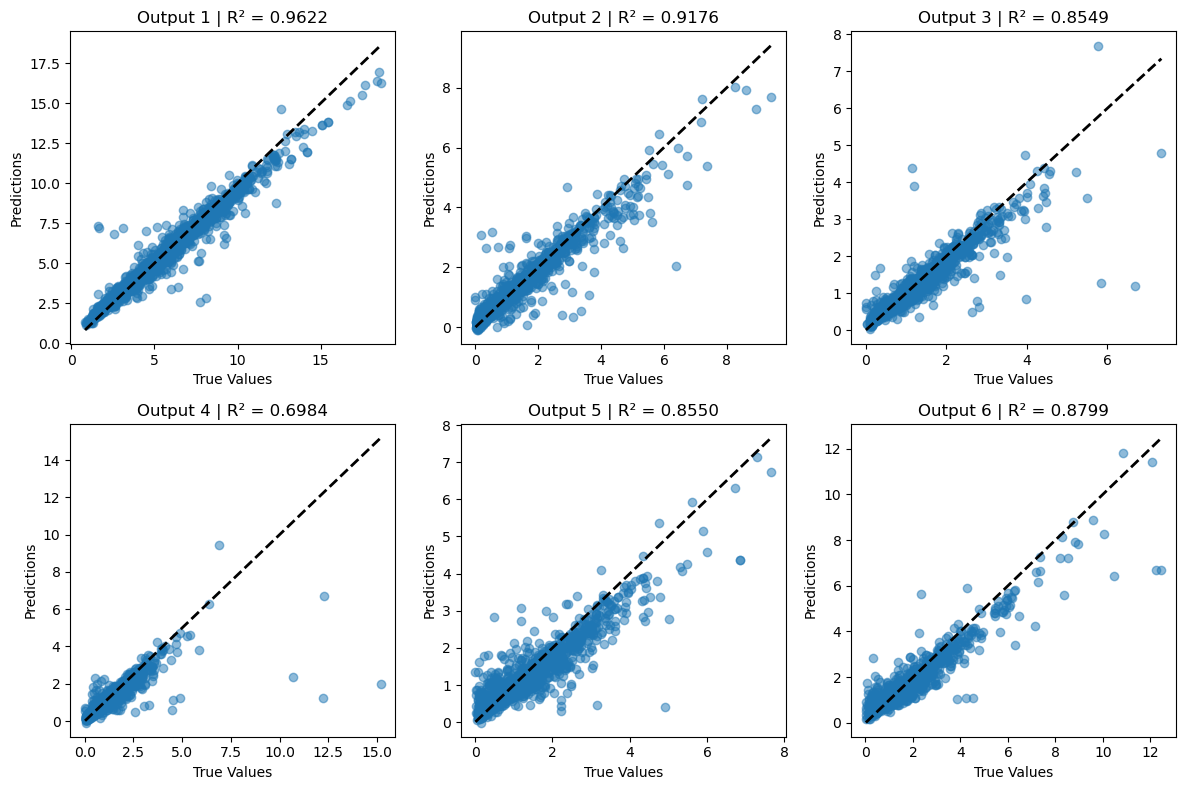

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

Y_val_npy = Y_val.cpu().detach().numpy()
val_outputs = model(X_val).cpu().detach().numpy()

num_outputs = 6
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i in range(num_outputs):
    y_true = Y_val_npy[:, i]
    y_pred = val_outputs[:, i]
    r2 = r2_score(y_true, y_pred)

    axes[i].scatter(y_true, y_pred, alpha=0.5)
    axes[i].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    axes[i].set_xlabel('True Values')
    axes[i].set_ylabel('Predictions')
    axes[i].set_title(f'Output {i+1} | R² = {r2:.4f}')

plt.tight_layout()
plt.show()
